In [2]:
import numpy as np
import sys
import os
import pandas as pd

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES

In [3]:
def make_bounds_exclusive(bounds, epsilon=1e-8):
    return [(low + epsilon, high - epsilon) for (low, high) in bounds]

def prepare_problem(PARAMETER_RANGES, dependent_param="Pc_des"):
    independent_params = {
        k: v for k, v in PARAMETER_RANGES.items()
        if k != dependent_param
    }
    # Add dummy variable to later compute dependent_param
    z_key = f"z_{dependent_param}"
    independent_params[z_key] = (0, 1)

    bounds = [v if isinstance(v, tuple) else [min(v), max(v)] for v in independent_params.values()]
    bounds = make_bounds_exclusive(bounds)

    problem = {
        "num_vars": len(independent_params),
        "names": list(independent_params.keys()),
        "bounds": bounds,
        "groups": list(independent_params.keys())  # optional but useful for group-based SA
    }
    return problem

problem = prepare_problem(PARAMETER_RANGES)

In [4]:
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import random

def generate_samples(problem, N=2, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    samples = sobol.sample(problem, N=N, calc_second_order= False, scramble= True, seed=seed)

    # Add a new column for the trajectory number
    trajectory_numbers = np.tile(np.arange(1, N + 1), (problem["num_vars"], 1)).flatten()

    return pd.DataFrame(samples, columns=problem["names"]), trajectory_numbers

def compute_dependent_param(df_samples, param_name="Pc_des", Pext=101325):
    z_key = f"z_{param_name}"
    Pa_des = df_samples["Pa_des"]
    z = df_samples[z_key]

    low = np.maximum(Pext, Pa_des - 0.5e5)
    high = np.maximum(Pext, Pa_des - 0.1e5)

    df_samples[param_name] = low + z * (high - low)
    df_samples = df_samples.drop(columns=z_key)
    return df_samples, low, high

df_samples, trajectory_numbers = generate_samples(problem, N=8)
df_samples, low, high = compute_dependent_param(df_samples)
print(df_samples.shape)

df_samples['e'] = np.round(df_samples['e'])


(168, 19)


In [5]:
""" def is_sample_in_bounds(sample, bounds_dict):
    """
"""
    Check if a sample is within the specified parameter bounds.
"""
"""
    Args:
        sample (dict): A dictionary of parameter values.
        bounds_dict (dict): A dictionary with parameter names as keys and tuples or lists as bounds.

    Returns:
        bool: True if all parameters are within bounds, False otherwise.
        dict: A dictionary of out-of-bound parameters with their values and bounds.
    """
"""    out_of_bounds = {}

    for key, bounds in bounds_dict.items():
        if key not in sample:
            continue  # skip if not part of the sample

        value = sample[key]

        if bounds is None:
            continue  # no bounds specified

        if isinstance(bounds, tuple):
            lower, upper = bounds
            if not (lower <= value <= upper):
                out_of_bounds[key] = {"value": value, "bounds": bounds}

        elif isinstance(bounds, list):
            if value not in bounds:
                out_of_bounds[key] = {"value": value, "allowed": bounds}

    return len(out_of_bounds) == 0, out_of_bounds

for sample in df_samples.to_dict(orient='records'):
    res = is_sample_in_bounds(sample, bounds_dict=PARAMETER_RANGES)
    if res[0] == False:
        print(res[1]) """

'    out_of_bounds = {}\n\n    for key, bounds in bounds_dict.items():\n        if key not in sample:\n            continue  # skip if not part of the sample\n\n        value = sample[key]\n\n        if bounds is None:\n            continue  # no bounds specified\n\n        if isinstance(bounds, tuple):\n            lower, upper = bounds\n            if not (lower <= value <= upper):\n                out_of_bounds[key] = {"value": value, "bounds": bounds}\n\n        elif isinstance(bounds, list):\n            if value not in bounds:\n                out_of_bounds[key] = {"value": value, "allowed": bounds}\n\n    return len(out_of_bounds) == 0, out_of_bounds\n\nfor sample in df_samples.to_dict(orient=\'records\'):\n    res = is_sample_in_bounds(sample, bounds_dict=PARAMETER_RANGES)\n    if res[0] == False:\n        print(res[1]) '

In [6]:
results = pd.read_pickle('../data/raw/sobol_sample_results_N8.pkl')

In [7]:
def replace_z_with_actual_param(problem, low, high, param_name="Pc_des"):
    z_key = f"z_{param_name}"
    idx = problem["names"].index(z_key)
    problem["names"][idx] = param_name
    problem["bounds"][idx] = (low.min(), high.max())
    problem["groups"][idx] = param_name
    return problem

problem = replace_z_with_actual_param(problem, low, high)

In [26]:
import skfda
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA

def perform_functional_PCA(results, output_key='Ucell', n_components = 3, cumulative_var = 0.95):

    Y_all = np.stack(results[output_key].values)
    n_outputs = Y_all.shape[1]
    
    fd = skfda.FDataGrid(data_matrix=Y_all, grid_points=range(n_outputs))
    
    # Initialize FPCA
    fpca = FPCA(n_components=n_components) 
    fpca.fit(fd)

    # Transform the data into FPCA scores (components' coefficients)
    Y_fpca_scores = fpca.transform(fd)

    # Explained variance by FPCA components
    explained_variance_ratio = np.cumsum(fpca.explained_variance_ratio_)
    
    # Select how many components to keep (explaining cumulative_var% of the variance)
    n_components_to_keep = np.argmax(explained_variance_ratio >= cumulative_var) + 1

    return Y_fpca_scores, explained_variance_ratio, n_components_to_keep

Y_fpca_scores, explained_var, n_comp_keep = perform_functional_PCA(results, output_key='Ucell')

In [30]:
def run_sobol_analysis( problem, Y_fpca_scores, num_resamples = 100,seed=42,n_components =1):
    np.random.seed(seed)
    random.seed(seed)

    sobol_all = []
    for i in range(n_components):
        analysis = sobol_analyze.analyze(
            problem=problem,
            Y=Y_fpca_scores[:, i],
            calc_second_order = False,
            num_resamples=num_resamples,
            conf_level=0.95,
            print_to_console=False,
            seed = 42
        )
        sobol_all.append({
            'S1': analysis['S1'],
            'S1_conf': analysis['S1_conf'],
            'ST': analysis['ST'],
            'ST_conf': analysis['ST_conf'],
            'param': problem['names'],
            'output_index': i
        })
    return sobol_all

sobol_all = run_sobol_analysis( problem,Y_fpca_scores ,num_resamples = 1000,n_components= n_comp_keep)


d:\Users\kju10\Documents\LMU-STATISTICS & DATA SCIENCE MASTER\WS2425\Consulting\project\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\env\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


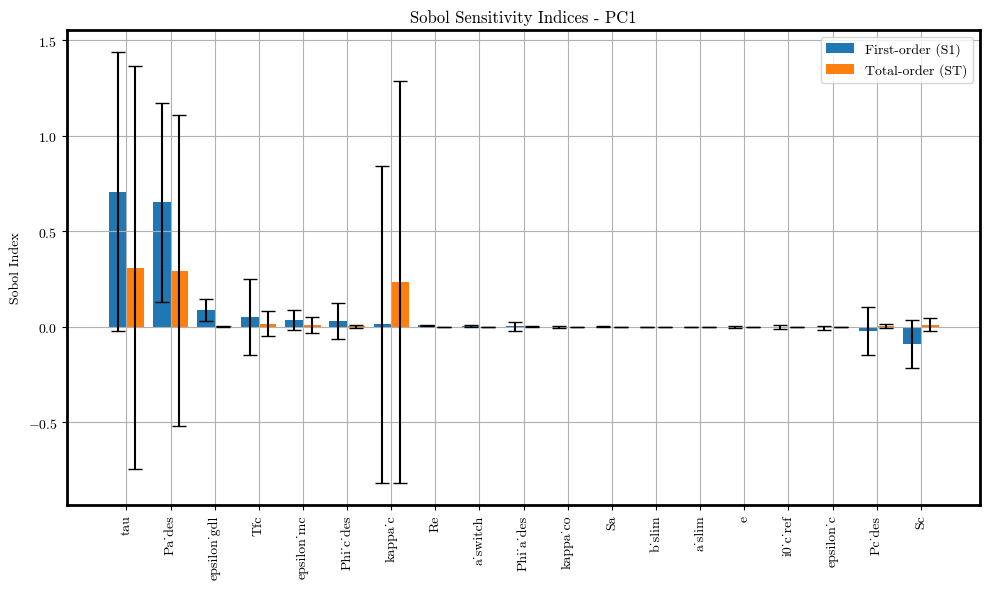

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sobol_sensitivity_per_index(sobol_all, figsize=(10, 6), sort_by='S1'):
    """
    Plots Sobol sensitivity analysis results with side-by-side horizontal bar plots for S1 and ST.
    
    Parameters:
    - sobol_all: list of dicts with keys 'S1', 'S1_conf', 'ST', 'ST_conf', 'param', and 'output_index'
    - figsize: tuple, size of each plot
    - sort_by: 'S1' or 'ST', which index to use for sorting bars (default is 'S1')
    """
    n_outputs = len(sobol_all)

    for i in range(n_outputs):
        result = sobol_all[i]
        S1 = np.array(result['S1'])
        S1_conf = np.array(result['S1_conf'])
        ST = np.array(result['ST'])
        ST_conf = np.array(result['ST_conf'])
        param_names = np.array(result['param'])

        sorted_indices = np.argsort(S1)[::-1]  # Sort descending by S1
        params_sorted = [param_names[i] for i in sorted_indices]
        S1_sorted = S1[sorted_indices]
        S1_conf_sorted = S1_conf[sorted_indices]
        ST_sorted = ST[sorted_indices]
        ST_conf_sorted = ST_conf[sorted_indices]

        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))

        x = np.arange(len(params_sorted))

        ax.bar(x - 0.2, S1_sorted, width=0.4, yerr=S1_conf_sorted, label='First-order (S1)', capsize=5)
        ax.bar(x + 0.2, ST_sorted, width=0.4, yerr=ST_conf_sorted, label='Total-order (ST)', capsize=5)

        ax.set_ylabel('Sobol Index')
        ax.set_title(f'Sobol Sensitivity Indices - PC{i+1}')
        ax.set_xticks(x)
        ax.set_xticklabels(params_sorted, rotation=90)
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

plot_sobol_sensitivity_per_index(sobol_all)